<a href="https://colab.research.google.com/github/davidegavio/amd-sm2l-project/blob/main/amd_sm2l_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint project AMD - SM2L
Davide Gavio - 930569





# Google Colab settings
Those actions need to be done in order to have the notebook working on Google Colab. 
If the notebook is executed elsewhere skip to the next cell.


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz   
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark pyspark seaborn kaggle scikit-learn matplotlib pandas progressbar2
!rm spark-3.0.1-bin-hadoop2.7.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

# PySpark settings


In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('amd-sm2l-project').master("local[*]").getOrCreate()

# Imports and settings


In [4]:
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
from matplotlib.pyplot import xlabel, ylabel
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType, Row
from pyspark.context import SparkContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import Imputer, MinMaxScaler, OneHotEncoder, VectorAssembler, StringIndexer, StandardScaler
from pyspark.mllib.linalg import DenseVector
from pyspark.mllib.regression import LabeledPoint, RidgeRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import ChiSqSelector, VectorIndexer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from zipfile import ZipFile
import os
from datetime import datetime
from pyspark.sql.types import *
import math
import kaggle

In [6]:
learning_rate = 0.000000001
n_iterations = 1
folds = 10
lowest_error = float('inf')
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
num_partitions = spark.sparkContext.defaultParallelism * 3

In [7]:
print('Parallelism info')
print("Default parallelism: {}".format(spark.sparkContext.defaultParallelism))
print("Custom parallelism: {}\n".format(num_partitions))

Parallelism info
Default parallelism: 2
Custom parallelism: 6



# Ridge Regression


In [8]:
import numpy as np 
import math
from datetime import datetime
from pyspark.sql import SparkSession
from progressbar import ProgressBar
 
 
 
class SparkRidgeRegression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
        variables X. 
        Parameters:
        -----------
        n_iterations: float
            The number of training iterations the algorithm will tune the weights for.
        learning_rate: float
            The step length that will be used when updating the weights."""
    def __init__(self, n_iterations, learning_rate, reg_factor):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.reg_factor = reg_factor
    
    def get_training_errors(self):
        return self.training_errors
    
    def set_training_errors(self, error):
        self.training_errors = error
 
    def squared_error(self, target, prediction):
        return (target - prediction) ** 2
 
    def root_mean_squared_error(self, predictions):
        return np.sqrt(predictions.map(lambda p: self.squared_error(*p)).mean())
 
    def mean_squared_error(self, predictions):
        return predictions.map(lambda p: self.squared_error(p[0], p[1])).mean()
 
    def mean_absolute_error(self, predictions):
        return np.abs(predictions.map(lambda prediction: prediction[1] - prediction[0]).reduce(lambda a, b: a + b))/predictions.count()
    
    def r2(self, predictions):
        mean_ = predictions.rdd.map(lambda t: t[0]).mean()
        sum_squares = predictions.rdd.map(lambda t: (t[0] - mean_)**2).sum()
        residual_sum_squares = predictions.rdd.map(lambda t: self.squared_error(*t)).sum()
        return 1 - (residual_sum_squares / sum_squares)
 
 
    def get_grad_sum(self, example):
        return (self.weights.dot(DenseVector(example.features)) - example.label) * example.features
 
    
    def fit(self, observations):
        progressbar = ProgressBar()
        features_number = len(observations.take(1)[0].features)
        self.training_errors = []
        self.weights = np.zeros(features_number)        
        start = datetime.now()
        # Do gradient descent for n_iterations
        for i in progressbar(range(self.n_iterations)):
          # Get the prediction given an example and the current weights
          predictions = observations.map(lambda example: self.predict(example)) # Result [label, prediction]
          # Calculate l2 loss
          regularization = self.reg_factor * self.weights
          self.training_errors.append(self.root_mean_squared_error(predictions))
          # Gradient of l2 loss w.r.t w
          grad_w = observations.map(lambda example: DenseVector(self.get_grad_sum(example))).reduce(lambda x, y: x + y) + regularization
          # Update the weights
          self.weights -= self.learning_rate * grad_w
          if i == self.n_iterations-1:
            float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
            predictions_df = float_predictions.toDF(['label', 'predictions'])
            print('From scratch training MSE: {}'.format(self.mean_squared_error(predictions=predictions)))
            print('From scratch training RMSE: {}'.format(self.root_mean_squared_error(predictions=predictions)))
            print('From scratch training MAE: {}'.format(self.mean_absolute_error(predictions=predictions)))
            print('From scratch training R2: {}'.format(self.r2(predictions_df)))
 
    def predict(self, example):
        return (example.label, self.weights.dot(DenseVector(example.features)))

# Utilities

In [9]:
def to_labeledpoint(row):
  row_dict = row.asDict()
  target = np.array(row_dict['target'][0])
  features = np.array(row_dict['scaled_features']).tolist()
  features.insert(0, 1.0)
  return LabeledPoint(target, features)
 
def remove_outliers(df):
  quantiles = df.approxQuantile(label_to_predict, [0.25, 0.75], 0.1)
  iqr = quantiles[1] - quantiles[0]
  if iqr != 0:
    df = df.filter(f.col(label_to_predict).between(quantiles[0] - (1.5 * iqr), quantiles[1] + (1.5 * iqr)))
  return df

# Dataset download

In [10]:
print('Downloading necessary files from Kaggle')
startTime = datetime.now()
kaggle.api.authenticate()
!mkdir ~/.kaggle
!echo '{"username":"davidegavio","key":"f4540434f20370f2bf34e2f9010b647e"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!mkdir ./datasets
!kaggle datasets download census/2013-american-community-survey -p ./datasets
with ZipFile('./datasets/2013-american-community-survey.zip', 'r') as zipObj:
   zipObj.extractall('./datasets/2013-american-community-survey')
os.remove('./datasets/2013-american-community-survey.zip')
print('Your download has been completed in: {}'.format(datetime.now() - startTime))

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mkdir: cannot create directory ‘./datasets’: File exists
 99% 909M/916M [00:05<00:00, 179MB/s]
100% 916M/916M [00:05<00:00, 170MB/s]
Your download has been completed in: 0:01:06.394393


# Preprocessing

In [149]:
%%time
print('Reading from csv')
df_a = spark.read.csv('/content/datasets/2013-american-community-survey/ss13pusa.csv', inferSchema=True, header=True).limit(35000)
# df_a = df_a.sample(False, 0.075, 6)
df_b = spark.read.csv('/content/datasets/2013-american-community-survey/ss13pusb.csv', inferSchema=True, header=True).limit(35000)
# df_b = df_b.sample(False, 0.075, 6)
df = df_a.union(df_b)
df = df.repartition(numPartitions=num_partitions)
label_to_predict = 'WAGP'
drop_thresh = .66
print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('The dataframe is divided in {} partitions'.format(df.rdd.getNumPartitions()))
print('==> Done\n')

Reading from csv
The shape is 70000 rows by 283 columns.
The dataframe is divided in 6 partitions
==> Done

CPU times: user 141 ms, sys: 24.4 ms, total: 165 ms
Wall time: 1min 24s


In [150]:
df.select(label_to_predict).describe().show()

+-------+------------------+
|summary|              WAGP|
+-------+------------------+
|  count|             58107|
|   mean|20750.508716677854|
| stddev| 37349.73921337099|
|    min|                 0|
|    max|            327000|
+-------+------------------+



In [151]:
%%time
print('Dropping useless columns, columns and rows with more than {}% of null values'.format(drop_thresh*100))
df = df.select(*(f.col(c).cast("float").alias(c) for c in df.columns)) # Casting the dataframe to float
df = df.drop('RT', 'PINCP ', 'PERNP' ) # Removing unnecessary columns
count_before = df.count()
thresh = int(len(df.columns)*drop_thresh)
df = df.dropna(thresh=thresh) # Dropping rows with more than 66% of null values
print('Dropped {} rows with less than {}% of non-null values'.format(count_before-df.count(), drop_thresh*100))
print('Keeping only rows with non-null value in target position')
count_before = df.count()
df = df.filter(df[label_to_predict].isNotNull()) # Keeping only the rows with not-null values in the corresponding label
data_agg = df.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns])
print('Dropped {} rows with with null in {} column'.format(count_before-df.count(), label_to_predict))
count_before = df.count()
col_before = len(df.columns)
over_thresh_col = df.select([(f.count(f.when(f.col(c).isNull(), c))/count_before).alias(c) for c in df.columns])
scheme = df.columns
null_distr = over_thresh_col.collect()[0].asDict().values()
for i in np.where(np.array(list(null_distr)) > ((1 - drop_thresh)))[0]:
  df = df.drop(scheme[i])
print('Dropped {} columns with less than {}% of non-null values'.format(col_before-len(df.columns), drop_thresh*100))
# print(f"The shape is {df.count():d} rows by {len(df.columns):d} columns.")
print('==> Done\n')

Dropping useless columns, columns and rows with more than 66.0% of null values
Dropped 0 rows with less than 66.0% of non-null values
Keeping only rows with non-null value in target position
Dropped 11893 rows with with null in WAGP column
Dropped 47 columns with less than 66.0% of non-null values
==> Done

CPU times: user 1.25 s, sys: 325 ms, total: 1.58 s
Wall time: 2min 10s


In [ ]:
df.select(label_to_predict).describe().show()

In [ ]:
%%time
print('Removing outliers')
df = remove_outliers(df)

In [ ]:
%%time
imput_strategy = 'mean'
print('Filling remaining null values with {} of each column'.format(imput_strategy))
imputer = Imputer() # Filling missing values with mean of the column
imputer.setInputCols(df.columns)
imputer.setOutputCols(df.columns)
imputer.setStrategy(imput_strategy)
df = imputer.fit(df).transform(df)
print('==> Done\n')

In [ ]:
df.select(label_to_predict).describe().show()

In [141]:
%%time
print('Rounding dataset')
progressbar = ProgressBar()
for col_name in progressbar(df.columns):
    df = df.withColumn(col_name, f.round(f.col(col_name), 3))

  0% (2 of 234) |                        | Elapsed Time: 0:00:00 ETA:   0:00:12

Rounding dataset


100% (234 of 234) |######################| Elapsed Time: 0:00:25 Time:  0:00:25


CPU times: user 670 ms, sys: 146 ms, total: 816 ms
Wall time: 25.7 s


In [ ]:
%%time
print('Choosing top features, assembling and scaling values')
feature_columns = df.columns
feature_columns.remove(label_to_predict)
features_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
feature_selector = ChiSqSelector(numTopFeatures=50, featuresCol="features", outputCol="selected_features", labelCol=label_to_predict)
target_assembler = VectorAssembler(inputCols=[label_to_predict], outputCol='target')
features_standardscaler = StandardScaler(inputCol='selected_features', outputCol='scaled_features', withStd=True, withMean=True)
df = Pipeline(stages=[features_assembler, target_assembler, feature_selector, features_standardscaler]).fit(df).transform(df)
print(f"The shape is {df.count():d} rows by {feature_selector.getNumTopFeatures():d} columns.")
print('==> Done\n')

In [ ]:
%%time
print('Creating labeled points')
to_label_df = df.select('target', 'scaled_features')
labeled_data = to_label_df.rdd.map(lambda row: to_labeledpoint(row))
print('Splitting in training set, validation set and test set')
labeled_train_df, labeled_validation_df, labeled_test_df = labeled_data.randomSplit(weights=[.6, .2, .2], seed=6)
labeled_train_df = labeled_train_df.repartition(num_partitions)
labeled_validation_df = labeled_validation_df.repartition(num_partitions)
labeled_test_df = labeled_test_df.repartition(num_partitions)
labeled_train_df.cache()
labeled_validation_df.cache()
labeled_test_df.cache()
print('Training set count: {} divided in {} partitions'.format(labeled_train_df.count(), labeled_train_df.getNumPartitions()))
print('Validation set count: {} divided in {} partitions'.format(labeled_validation_df.count(), labeled_validation_df.getNumPartitions()))
print('Test set count: {} divided in {} partitions'.format(labeled_test_df.count(), labeled_test_df.getNumPartitions()))
print('==> Done\n')

In [ ]:
print('Training and predictions will work on ')
labeled_data.take(2)

# Best model individuation

In [ ]:
%%time
from progressbar import ProgressBar
progressbar = ProgressBar()
print('Finding regularization factor using grid search')
best_reg_factor = 0
mean_squared_errors = []
for candidate_reg_factor in progressbar(alphas):
  print('Trying using {} as regularization factor'.format(candidate_reg_factor))
  mean_squared_error = 0
  candidate_rr = SparkRidgeRegression(n_iterations=n_iterations, learning_rate=learning_rate, reg_factor=candidate_reg_factor)
  candidate_rr.fit(labeled_train_df)
  print('Validating')
  candidate_pred = labeled_validation_df.map(lambda prediction: candidate_rr.predict(prediction))
  mean_squared_error = candidate_rr.mean_squared_error(predictions=candidate_pred)
  mean_squared_errors.append(mean_squared_error)
  if mean_squared_error < lowest_error:
    print('Currently best regularization factor: {}'.format(candidate_reg_factor))
    best_reg_factor = candidate_reg_factor
    lowest_error = mean_squared_error
print('Grid search terminated, chosen regularization factor: {}'.format(best_reg_factor))

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


MSE with different regularization factors


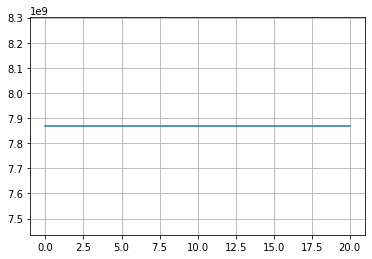

In [ ]:
print('MSE with different regularization factors')
sn.lineplot(alphas, mean_squared_errors).grid()

# Training and evaluation

In [ ]:
%%time
print('Training with {} as learning rate and {} as regularization factor'.format(learning_rate, 0.1))
spark_rr = SparkRidgeRegression(n_iterations=300, learning_rate=0.00001, reg_factor=0.01)
now = datetime.now()
spark_rr.fit(labeled_train_df)
print('==> Done in {}\n'.format(datetime.now()-now))

In [ ]:
%%time
print('Predicting')
predictions = labeled_test_df.map(lambda prediction: spark_rr.predict(prediction))
float_predictions = predictions.map(lambda xs: [float(x) for x in xs])
predictions_df = float_predictions.toDF(['label', 'predictions'])
print('==> Done\n')

In [ ]:
%%time
root_mean_squared_error = spark_rr.root_mean_squared_error(predictions=predictions)
mean_squared_error = spark_rr.mean_squared_error(predictions=predictions)
mean_absolute_error = spark_rr.mean_absolute_error(predictions=predictions)
r2_score = spark_rr.r2(predictions_df)
print('From scratch test MSE: {}'.format(mean_squared_error))
print('From scratch test RMSE: {}'.format(root_mean_squared_error))
print('From scratch test MAE: {}'.format(mean_absolute_error))
print('From scratch test R2: {}'.format(r2_score))
print('==> Done\n')

In [ ]:
fig = plt.figure(figsize = (12, 7))
g = sn.lineplot(x = np.arange(spark_rr.n_iterations), y = spark_rr.training_errors, color = 'crimson').grid()
fig.suptitle('Plotting training error during GD iterations', fontsize = 20)
plt.xlabel('Iteration', fontsize = 14)
plt.ylabel('Training error', fontsize = 14)